<a href="https://colab.research.google.com/github/anasayago/previsionVuelos/blob/main/optimizacion_aeroportuaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevision de Vuelos
Modelo de regresión para predecir los retrasos en vuelos

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import yellowbrick

print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de scikit-learn (sklearn): {sklearn.__version__}')
print(f'Versión de seaborn: {sns.__version__}')
print(f'Versión de yellowbrick: {yellowbrick.__version__}')

Versión de pandas: 2.2.2
Versión de numpy: 2.0.2
Versión de scikit-learn (sklearn): 1.6.1
Versión de seaborn: 0.13.2
Versión de yellowbrick: 1.5


In [2]:
datos = pd.read_csv('flights.csv')
datos.shape

(71175, 11)

In [3]:
datos.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271


## Conocer los Metadatos

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       71175 non-null  int64  
 1   airline         71175 non-null  object 
 2   aircraft_type   71175 non-null  object 
 3   schengen        71175 non-null  object 
 4   origin          71175 non-null  object 
 5   arrival_time    71175 non-null  float64
 6   departure_time  71175 non-null  float64
 7   day             71175 non-null  int64  
 8   year            71175 non-null  int64  
 9   is_holiday      71175 non-null  bool   
 10  delay           71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [5]:
datos.describe()

,flight_id,arrival_time,departure_time,day,year,delay
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


In [11]:
datos.describe(include='object')

,airline,aircraft_type,schengen,origin
count,71175,71175,71175,71175
unique,3,6,2,10
top,BZ,Airbus A320,schengen,TZF
freq,47598,30778,42569,14162


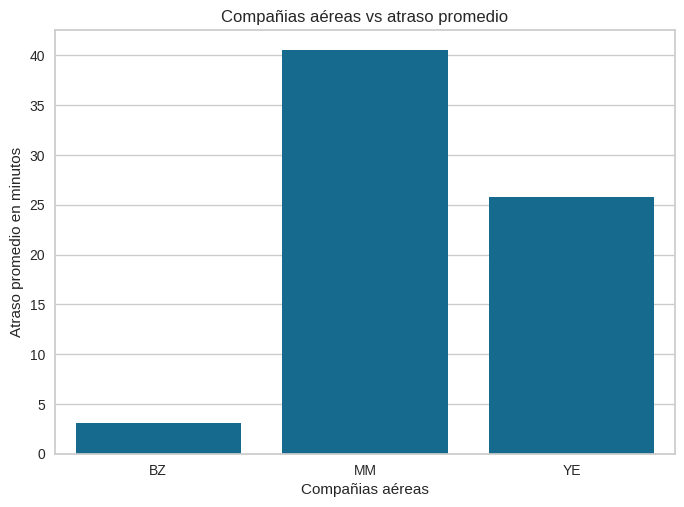

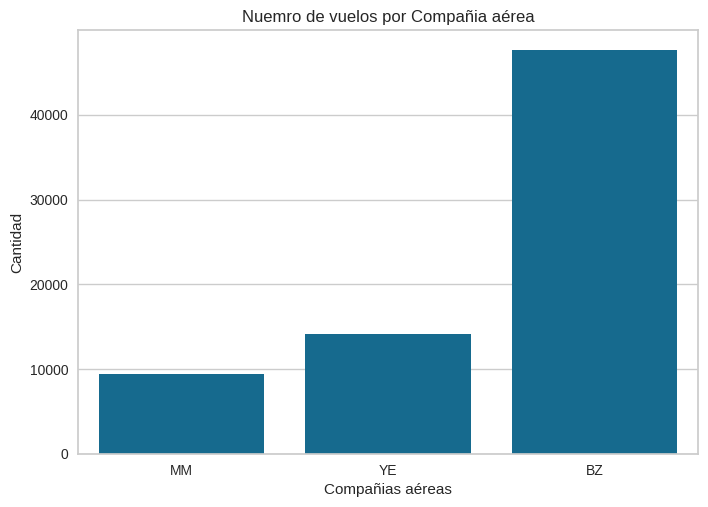

In [16]:
import matplotlib.pyplot as plt
avg_delay = datos.groupby('airline')['delay'].mean().reset_index()
sns.barplot(x='airline',y='delay',data=avg_delay)
plt.title('Compañias aéreas vs atraso promedio')
plt.xlabel('Compañias aéreas')
plt.ylabel('Atraso promedio en minutos')
plt.show()

sns.countplot(data=datos,x='airline')
plt.title('Nuemro de vuelos por Compañia aérea')
plt.xlabel('Compañias aéreas')
plt.ylabel('Cantidad')
plt.show()


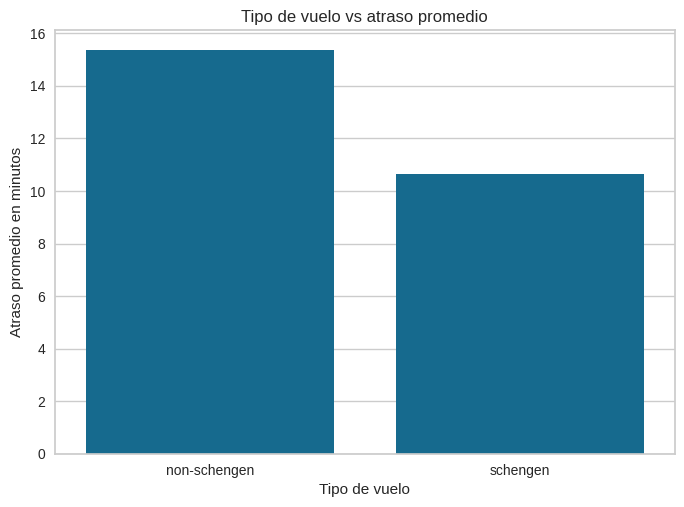

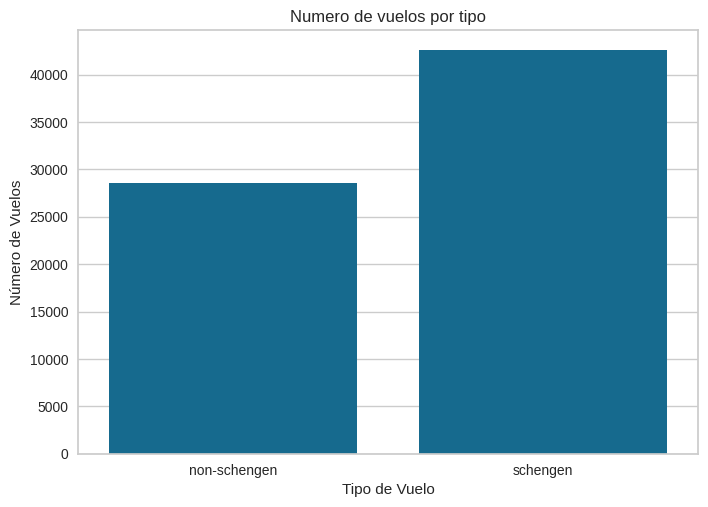

In [20]:
avg_delay = datos.groupby('schengen')['delay'].mean().reset_index()
sns.barplot(x='schengen',y='delay',data=avg_delay)
plt.title('Tipo de vuelo vs atraso promedio')
plt.xlabel('Tipo de vuelo')
plt.ylabel('Atraso promedio en minutos')
plt.show()

sns.countplot(data=datos,x='schengen')
plt.title('Numero de vuelos por tipo')
plt.xlabel('Tipo de Vuelo')
plt.ylabel('Número de Vuelos')
plt.show()

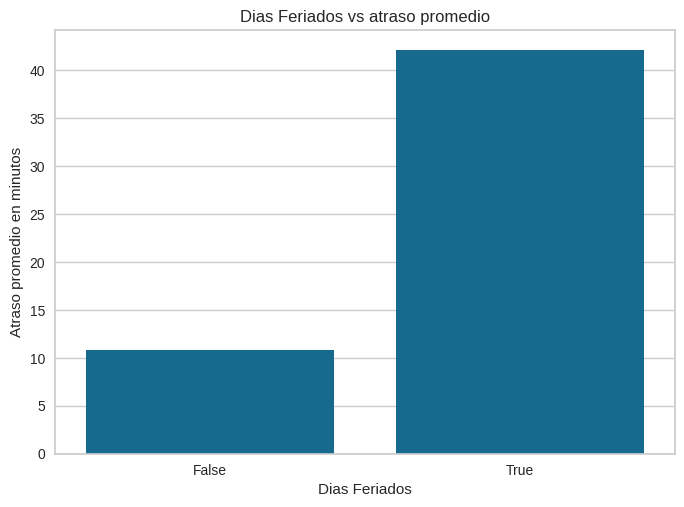

In [22]:
#Ocurre atrasos en dias feriados
avg_delay = datos.groupby('is_holiday')['delay'].mean().reset_index()
sns.barplot(x='is_holiday',y='delay',data=avg_delay)
plt.title('Dias Feriados vs atraso promedio')
plt.xlabel('Dias Feriados')
plt.ylabel('Atraso promedio en minutos')
plt.show()


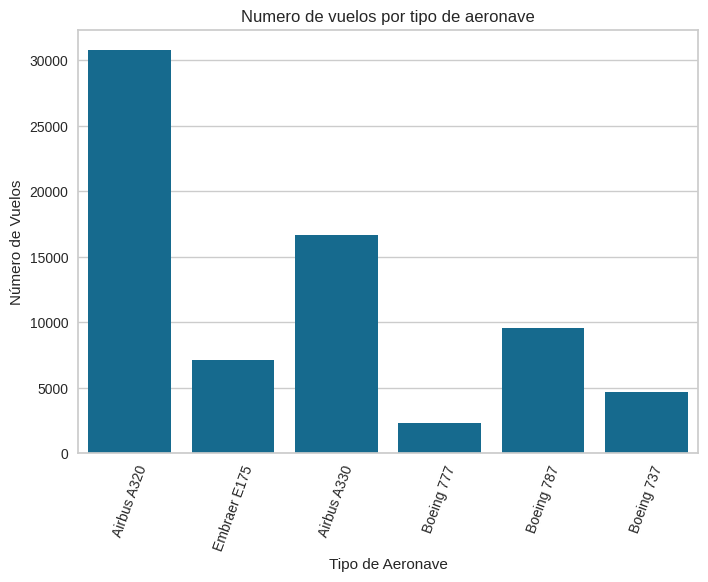

In [25]:
order = datos['aircraft_type'].value_counts().index
sns.countplot(data=datos,x='aircraft_type')
plt.title('Numero de vuelos por tipo de aeronave')
plt.xticks(rotation=70)
plt.xlabel('Tipo de Aeronave')
plt.ylabel('Número de Vuelos')
plt.show()

## Distribución de los Datos
Leer regla de Freedman Diaconis

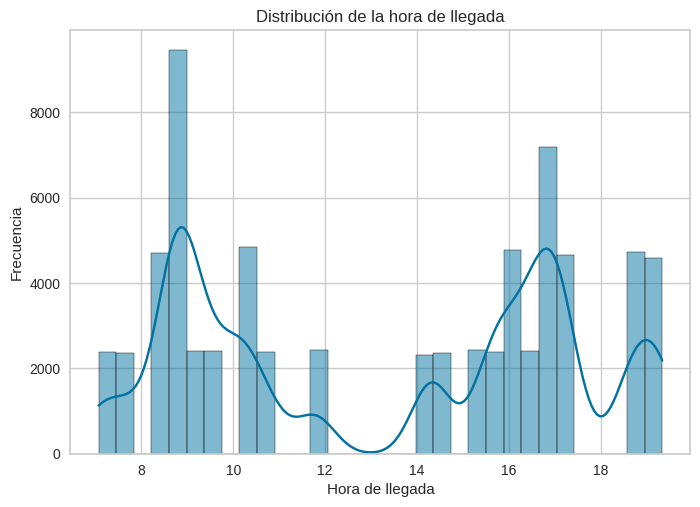

In [27]:
sns.histplot(data=datos,x='arrival_time',kde=True)
plt.title('Distribución de la hora de llegada')
plt.xlabel('Hora de llegada')
plt.ylabel('Frecuencia')
plt.show()

In [28]:
def ancho_bin(df,columna):
  q75,q25 =np.percentile(df[columna],[75,25])
  iqr = q75-q25
  ancho = 2 * iqr * np.power(len(df[columna]),-1/3)
  return ancho

Ancho de bin: 0.3846176245547029


<Axes: xlabel='arrival_time', ylabel='Count'>

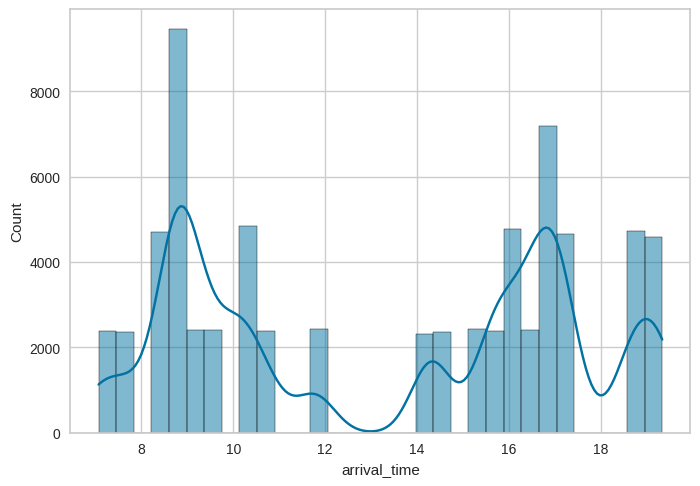

In [30]:
bin_width = ancho_bin(datos,'arrival_time')
print(f'Ancho de bin: {bin_width}')
sns.histplot(data=datos,x='arrival_time',kde=True,binwidth=bin_width)

Ancho de bin: 0.3558030990133985


<Axes: xlabel='departure_time', ylabel='Count'>

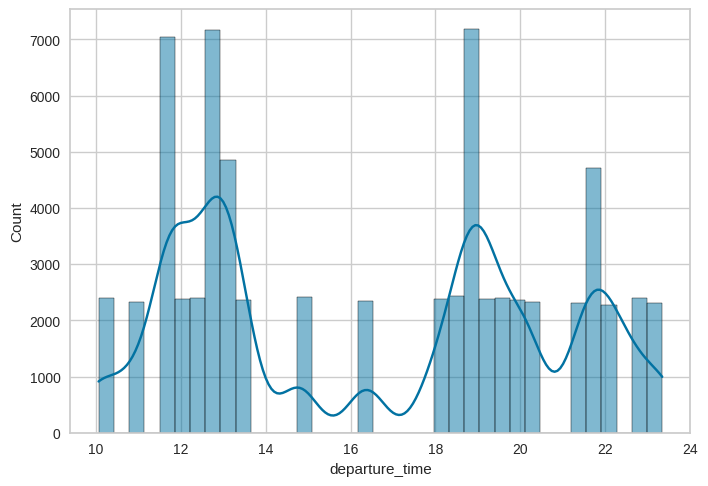

In [31]:
bin_width = ancho_bin(datos,'departure_time')
print(f'Ancho de bin: {bin_width}')
sns.histplot(data=datos,x='departure_time',kde=True,binwidth=bin_width)

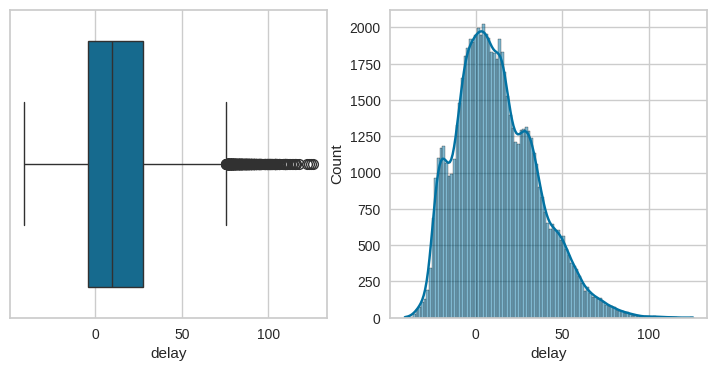

In [41]:
atraso_promedio = datos['delay'].mean()
atraso_mediana = datos['delay'].median()
fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.boxplot(data=datos,x='delay',ax=ax[0])
sns.histplot(data=datos,x='delay',kde=True,ax=ax[1])
plt.show()

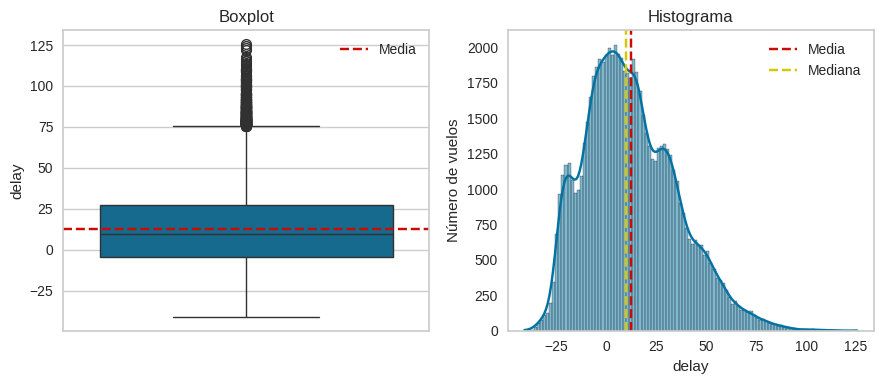

In [44]:
media_retraso = datos['delay'].mean()
mediana_retraso = datos['delay'].median()

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(data=datos, y='delay', ax=axes[0])
axes[0].set_title('Boxplot')

axes[0].axhline(y=media_retraso, color='r', linestyle='--', label='Media')
axes[0].legend()

ancho_bin_delay = ancho_bin(datos, 'delay')
sns.histplot(data=datos, x='delay', ax=axes[1], kde=True, binwidth=ancho_bin_delay)
plt.ylabel('Número de vuelos')
plt.grid(False)
axes[1].set_title('Histograma')

axes[1].axvline(x=media_retraso, color='r', linestyle='--', label='Media')
axes[1].axvline(x=mediana_retraso, color='y', linestyle='--', label='Mediana')
axes[1].legend()

plt.tight_layout()
plt.show()

## Clase 2

In [45]:
datos.columns

Index(['flight_id', 'airline', 'aircraft_type', 'schengen', 'origin',
       'arrival_time', 'departure_time', 'day', 'year', 'is_holiday', 'delay'],
      dtype='object')

In [47]:
datos['date'] = datos['year'].astype(str)+'-'+(datos['day']+1).astype(str)
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%j')
datos.tail(2)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,datos,date
71173,5,BZ,Airbus A320,schengen,ZQO,9.344097,12.344097,364,2022,True,56.758844,2022-365,2022-12-31
71174,29,BZ,Boeing 737,schengen,ZQO,8.591208,11.591208,364,2022,True,41.401648,2022-365,2022-12-31


In [49]:
datos['is_weekend'] = datos['date'].dt.weekday.isin([5,6])
datos['day_name'] = datos['date'].dt.day_name()
datos.sample(5)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,datos,date,is_weekend,day_name
28492,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,74,2015,False,-31.687310,2015-75,2015-03-16,False,Monday
56800,5,BZ,Airbus A320,schengen,ZQO,9.344097,12.344097,136,2020,False,-5.997589,2020-137,2020-05-16,True,Saturday
21362,25,BZ,Boeing 777,non-schengen,CSF,19.341235,23.341235,329,2013,False,16.830309,2013-330,2013-11-26,False,Tuesday
22810,21,BZ,Boeing 737,schengen,FJB,7.065594,10.065594,60,2014,False,18.805119,2014-61,2014-03-02,True,Sunday
47553,16,MM,Airbus A320,non-schengen,CSF,17.041281,20.041281,250,2018,True,70.605787,2018-251,2018-09-08,True,Saturday
